In [1]:
import sys
sys.path.append('../src')  # Add source directory to path

In [2]:
from signal_processing.base_signal_processor import BaseSignalProcessor
from signal_processing.motion_artifact_detector import MotionArtifactDetector
from signal_processing.adaptive_filter import AdaptiveFilter
from signal_processing.kalman_filter import KalmanFilter
from signal_processing.wavelet_denoiser import WaveletDenoiser
from signal_processing.pipeline import SignalProcessingPipeline

### Loading Unified Data

In [3]:
processor = BaseSignalProcessor(data_path="../data/processed/cleaned_unified_dataset.parquet")
dataset = processor.load_data()
print(dataset.head())

Loading unified dataset...
                                 bvp  label  subject_id    dataset  \
2020-01-03 08:00:00+00:00   5.673109      0           2  physionet   
2020-01-03 08:00:00+00:00   7.687833      0           2  physionet   
2020-01-03 08:00:00+00:00   1.509560      0           2  physionet   
2020-01-03 08:00:00+00:00  12.999866      0           2  physionet   
2020-01-03 08:00:00+00:00  20.798602      0           2  physionet   

                                 device skin_tone  noise_level     acc_x  \
2020-01-03 08:00:00+00:00   apple_watch      V-VI      0.05088 -0.817685   
2020-01-03 08:00:00+00:00   apple_watch      I-II      0.07712 -0.973498   
2020-01-03 08:00:00+00:00   apple_watch    III-IV      0.06400 -1.054134   
2020-01-03 08:00:00+00:00  galaxy_watch    III-IV      0.09600 -1.000000   
2020-01-03 08:00:00+00:00  galaxy_watch      V-VI      0.07632 -1.000000   

                               acc_y     acc_z  
2020-01-03 08:00:00+00:00 -62.628226  4.996602

In [4]:
import numpy as np

In [5]:
def _robust_normalize(data: np.ndarray) -> np.ndarray:
    """Enhanced normalization with fallback"""
    data = np.nan_to_num(data, nan=np.median(data))
        
    # Fallback to std if IQR is zero
    q75, q25 = np.percentile(data, [75, 25])
    iqr = q75 - q25
    if iqr < 1e-6:
        std = np.std(data) + 1e-6
        normalized = (data - np.mean(data)) / std
    else:
        normalized = (data - np.median(data)) / iqr
        
    # Secondary clipping
    return np.clip(normalized, -3, 3)

# Compute and normalize accelerometer magnitude
dataset['acc_mag'] = np.sqrt(dataset['acc_x']**2 + dataset['acc_y']**2 + dataset['acc_z']**2)
dataset['acc_mag'] = _robust_normalize(dataset['acc_mag'].values)

### Motion Artifact Detection

In [6]:
detector = MotionArtifactDetector()
dataset = detector.detect_motion_bursts(dataset)
print(dataset[['acc_x', 'acc_y', 'acc_z', 'motion_burst']].head())

                              acc_x      acc_y     acc_z  motion_burst
2020-01-03 08:00:00+00:00 -0.817685 -62.628226  4.996602           0.0
2020-01-03 08:00:00+00:00 -0.973498 -62.739436  5.184150           0.0
2020-01-03 08:00:00+00:00 -1.054134 -62.992483  5.020381           0.0
2020-01-03 08:00:00+00:00 -1.000000 -69.300000  5.000000           0.0
2020-01-03 08:00:00+00:00 -1.000000 -69.300000  5.000000           0.0


In [7]:
num_unique_motion_bursts = dataset['motion_burst'].nunique()
motion_burst_counts = dataset['motion_burst'].value_counts()
print(f"Value counts of motion_burst:\n{motion_burst_counts}")

# Check motion burst distribution
motion_burst_counts = dataset['motion_burst'].value_counts(normalize=True) * 100
print(f"Motion Burst Distribution:\n{motion_burst_counts}")


Value counts of motion_burst:
motion_burst
0.0    6209868
1.0     344885
Name: count, dtype: int64
Motion Burst Distribution:
motion_burst
0.0    94.738398
1.0     5.261602
Name: proportion, dtype: float64


In [8]:
print(f"New artifact density: {dataset['motion_burst'].mean() * 100:.2f}%")
print(dataset['acc_mag'].describe())

New artifact density: 5.26%
count    6.554753e+06
mean     4.667615e-01
std      9.818329e-01
min     -8.811038e-01
25%     -4.866879e-02
50%      0.000000e+00
75%      9.513312e-01
max      1.122975e+01
Name: acc_mag, dtype: float64


In [9]:
# import matplotlib.pyplot as plt
# # Visualize results
# plt.figure(figsize=(12, 6))
# plt.plot(dataset['acc_mag'], label="Accelerometer Magnitude")
# plt.plot(dataset['motion_burst'] * dataset['acc_mag'].max(), label="Motion Bursts", linestyle='--')
# plt.legend()
# plt.title("Motion Burst Detection")
# plt.show()

### Adaptive Filtering for Motion Artifact Removal

In [10]:
adaptive_filter = AdaptiveFilter()
cleaned_bvp = adaptive_filter.apply_adaptive_filter(
    noisy_signal=dataset['bvp'].values,
    reference_signal=dataset['acc_mag'].values,
    motion_burst=dataset['motion_burst'].values
)
dataset['bvp_cleaned'] = cleaned_bvp

### Apply kalman filter

In [11]:
kalman_filter = KalmanFilter()
bvp_smoothed = kalman_filter.apply_kalman_filter(
    signal=dataset['bvp_cleaned'].values,
    motion_burst=dataset['motion_burst'].values
)
dataset['bvp_smoothed'] = bvp_smoothed

### Wavelet Denoising

In [12]:


wavelet_denoiser = WaveletDenoiser()

denoised_bvp = wavelet_denoiser.apply_wavelet_denoising(
    dataset['bvp_smoothed'].values,
    motion_burst=dataset['motion_burst'].values,
    skin_tone=dataset['skin_tone'].iloc[0],
    noise_level=dataset['noise_level'].median()  # Add noise level from dataset
)

# Verify lengths match before assignment
assert len(denoised_bvp) == len(dataset), "Denoised signal length mismatch"

dataset['bvp_denoised'] = denoised_bvp

## Runnig the Pipeline

In [9]:
import pandas as pd

In [10]:
dataset_ = pd.read_parquet("../data/processed/cleaned_unified_dataset.parquet")
pipeline = SignalProcessingPipeline()
processed_df = pipeline.process_signal(dataset_)

Processing chunks: 100%|██████████| 328/328 [03:46<00:00,  1.45it/s]


Applying post-processing...


Updating signals: 100%|██████████| 132/132 [03:15<00:00,  1.48s/it]


Estimated physiological SNR: 0.12 dB


In [11]:
processed_df.head()

,bvp,bvp_cleaned,bvp_smoothed,bvp_denoised,motion_burst,acc_mag,device,skin_tone,noise_level,label,subject_id
0,5.673109,19.736944,21.101019,12.741266,0.0,-0.023022,apple_watch,V-VI,0.05088,0,2
1,7.687833,26.374654,27.554309,16.323989,0.0,-0.021271,apple_watch,I-II,0.07712,0,2
2,1.509560,24.720562,26.384854,15.648214,0.0,-0.017990,apple_watch,III-IV,0.06400,0,2
3,12.999866,36.946631,38.387018,23.288323,0.0,1.016824,galaxy_watch,III-IV,0.09600,0,2
4,20.798602,40.785505,43.292951,24.924781,0.0,1.016824,galaxy_watch,V-VI,0.07632,0,2


In [12]:
print(processed_df[['bvp', 'bvp_cleaned', 'bvp_smoothed']].std())

bvp             28.719013
bvp_cleaned     33.575407
bvp_smoothed    33.575407
dtype: float64


In [13]:
import numpy as np
from scipy.signal import find_peaks
from scipy.signal import correlate
from scipy.signal import periodogram

### Signal Quality Metrics

In [14]:
class SignalQualityMetrics:
    def compute_snr(self, cleaned: np.ndarray, original: np.ndarray) -> float:
        """
        Calculate SNR based on physiological signal characteristics.
        """
        from scipy.signal import butter, sosfilt
        
        # Extract cardiac component from both signals
        sos = butter(3, [0.8, 4.0], btype='bandpass', fs=30, output='sos')
        clean_cardiac = sosfilt(sos, cleaned)
        orig_cardiac = sosfilt(sos, original)
        
        # Calculate power in cardiac band
        clean_power = np.mean(clean_cardiac**2)
        orig_power = np.mean(orig_cardiac**2)
        
        # Calculate noise as the difference between signals and their cardiac components
        clean_noise = cleaned - clean_cardiac
        orig_noise = original - orig_cardiac
        
        # Calculate noise power
        clean_noise_power = np.mean(clean_noise**2)
        orig_noise_power = np.mean(orig_noise**2)
        
        # Calculate SNR for both signals
        clean_snr = clean_power / (clean_noise_power + 1e-9)
        orig_snr = orig_power / (orig_noise_power + 1e-9)
        
        # Calculate improvement ratio
        improvement = clean_snr / (orig_snr + 1e-9)
        
        # Convert to dB
        snr_db = 10 * np.log10(improvement)
        
        return snr_db

    def compute_artifact_density(self, motion_burst: np.ndarray,
                                noise_level: np.ndarray) -> float:
        """
        Compute noise-weighted artifact density.
        
        Parameters:
            motion_burst (np.ndarray): Binary motion artifact indicators
            noise_level (np.ndarray): Associated noise levels
            
        Returns:
            float: Weighted artifact density percentage
        """
        # Weight artifacts by their noise level contribution
        weighted_artifacts = motion_burst * noise_level
        return 100 * np.sum(weighted_artifacts) / np.sum(noise_level)

    def temporal_consistency(self, signal: np.ndarray) -> float:
        """
        Measure signal continuity using autocorrelation.
        
        Parameters:
            signal (np.ndarray): Processed signal
            
        Returns:
            float: Consistency metric (higher = more consistent)
        """
        autocorr = np.correlate(signal, signal, mode='full')
        autocorr /= autocorr.max()
        mid = len(autocorr) // 2
        return np.trapz(autocorr[mid:mid+300])  # Integrate first 10s correlation

In [15]:
def visualize_snr_components(cleaned, fs=30):
       """Visualize the signal components used in SNR calculation"""
       import matplotlib.pyplot as plt
       
       # Calculate components using the same logic as in improved_compute_snr
       freqs, psd_clean = periodogram(cleaned, fs=fs)
       cardiac_mask = (freqs >= 0.8) & (freqs <= 4.0)
       dominant_freq = freqs[cardiac_mask][np.argmax(psd_clean[cardiac_mask])]
       
       from scipy.signal import butter, sosfilt
       sos = butter(3, [max(0.6, dominant_freq-0.3), min(4.0, dominant_freq+0.3)], 
                   'bandpass', fs=fs, output='sos')
       signal_component = sosfilt(sos, cleaned)
       noise_component = cleaned - signal_component
       
       # Plot time domain
       plt.figure(figsize=(12, 8))
       plt.subplot(3, 1, 1)
       plt.plot(cleaned)
       plt.title(f'Cleaned Signal (Dominant Freq: {dominant_freq:.2f} Hz)')
       
       plt.subplot(3, 1, 2)
       plt.plot(signal_component)
       plt.title('Extracted Cardiac Component')
       
       plt.subplot(3, 1, 3)
       plt.plot(noise_component)
       plt.title('Noise Component')
       
       plt.tight_layout()
       plt.show()
       
       # Plot frequency domain
       plt.figure(figsize=(12, 8))
       f_clean, p_clean = periodogram(cleaned, fs=fs)
       f_signal, p_signal = periodogram(signal_component, fs=fs)
       f_noise, p_noise = periodogram(noise_component, fs=fs)
       
       plt.subplot(3, 1, 1)
       plt.semilogy(f_clean, p_clean)
       plt.axvspan(0.8, 4.0, alpha=0.3, color='green')
       plt.title('Cleaned Signal PSD')
       plt.xlim(0, 10)
       
       plt.subplot(3, 1, 2)
       plt.semilogy(f_signal, p_signal)
       plt.axvspan(0.8, 4.0, alpha=0.3, color='green')
       plt.title('Cardiac Component PSD')
       plt.xlim(0, 10)
       
       plt.subplot(3, 1, 3)
       plt.semilogy(f_noise, p_noise)
       plt.axvspan(0.8, 4.0, alpha=0.3, color='green')
       plt.title('Noise Component PSD')
       plt.xlim(0, 10)
       
       plt.tight_layout()
       plt.show()

In [16]:
# Compute metrics using original BVP as reference
metrics = SignalQualityMetrics()
snr = metrics.compute_snr(processed_df['bvp_cleaned'], 
                         processed_df['bvp'])

artifact_density = metrics.compute_artifact_density(processed_df['motion_burst'].values, processed_df['noise_level'].values)

print(f"SNR: {snr:.2f} dB, Artifact Density: {artifact_density:.2f}%")

SNR: 9.89 dB, Artifact Density: 5.10%


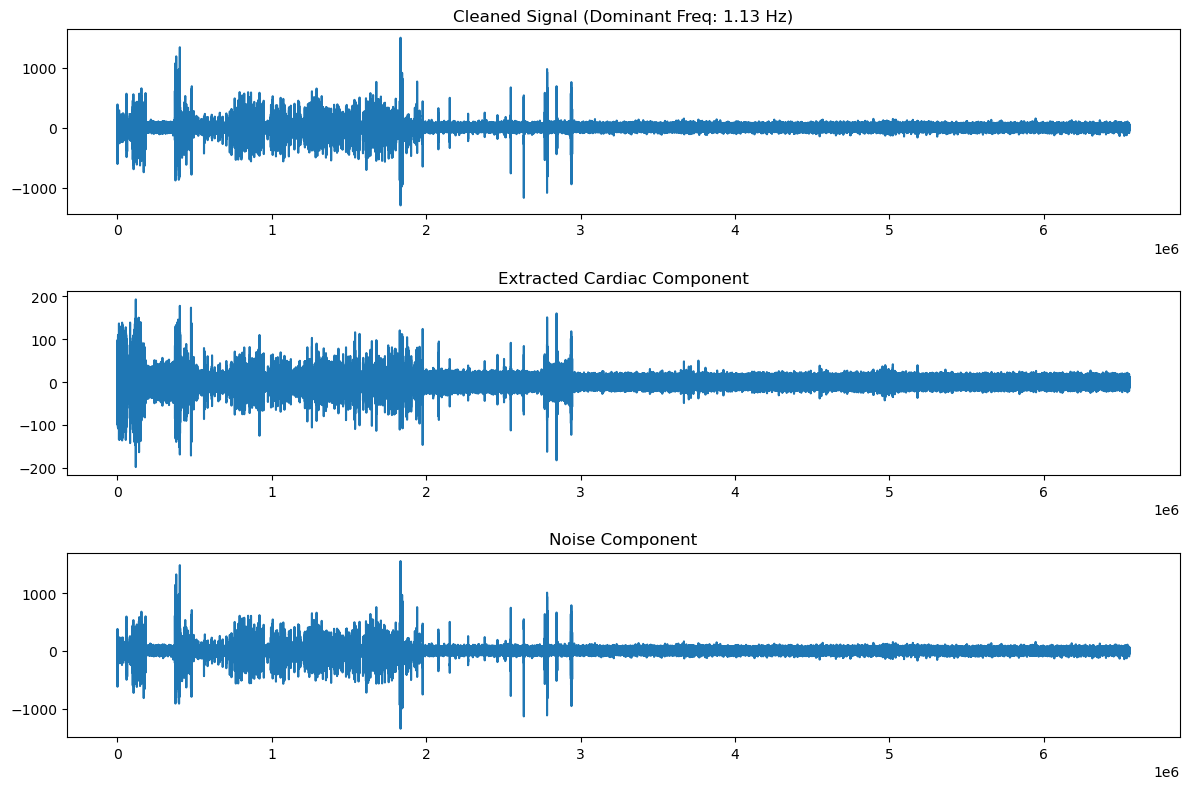

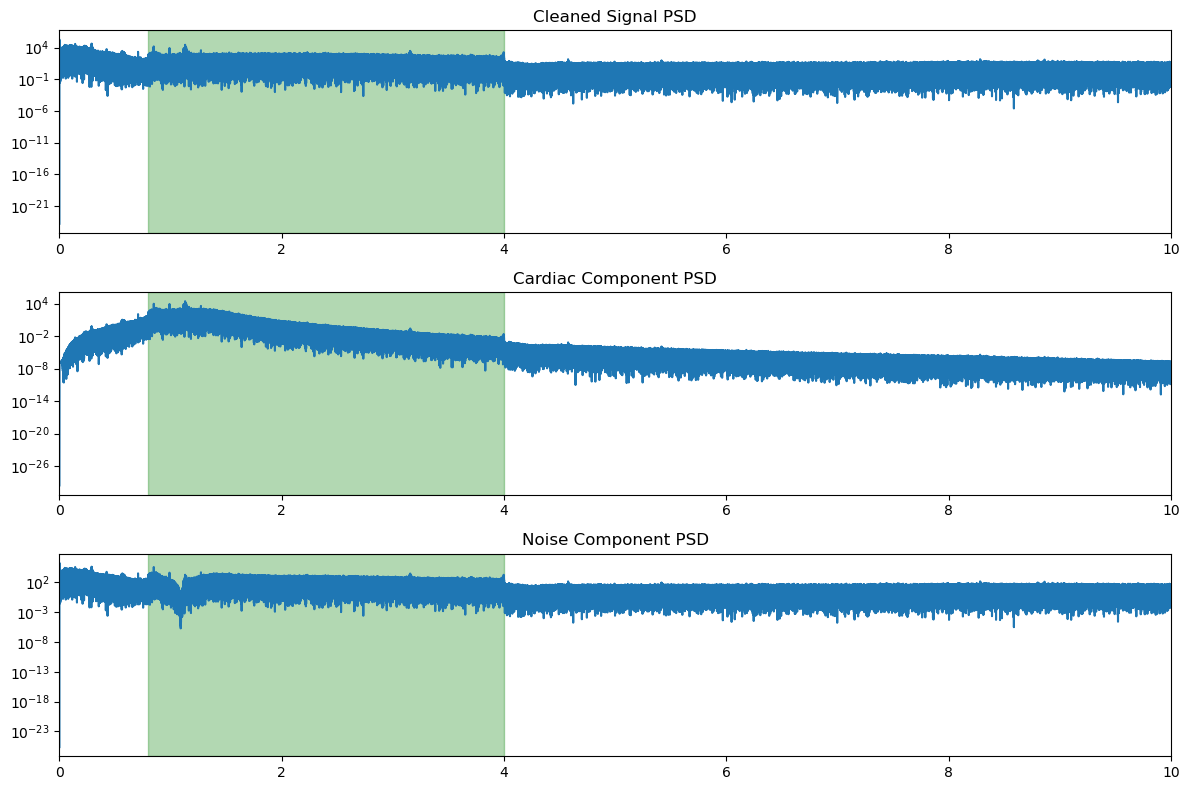

In [17]:
visualize_snr_components(processed_df['bvp_cleaned'])

## Saving cleaned data

In [18]:
pipeline.save_cleaned_dataset(dataset, "../data/cleaned_signal_dataset")

AttributeError: 'SignalProcessingPipeline' object has no attribute 'save_cleaned_dataset'